In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%tensorflow_version 1.x
%matplotlib inline


num_classes = 2

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/Project_GogiMaster/'

Made_X = np.load(gdrive_path + 'datasets/gogi_to_np.npy') / 255. 
Made_Y = np.load(gdrive_path + 'datasets/y_label.npy').reshape(-1, 1)

# Made_X = Made_X[:-2]
# print(Made_X[0].max())
# breakpoint
# Made_Y = Made_Y[:-2]


print(Made_X.shape)
print(Made_Y.shape)

row = Made_X.shape[1]
col = Made_X.shape[2]
rgb = Made_X.shape[3]

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                   shuffle=False)

X_train = X_train.astype('float32').reshape(-1, row, col, rgb)
X_val = X_val.astype('float32').reshape(-1, row, col, rgb)
print(X_train.shape)
print(X_val.shape)

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 

# Data Class Weight
from sklearn.utils import class_weight

# print(Y_train[:, 0])
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(Y_train[:, 0]),
                                                  Y_train[:, 0])
class_weights = dict(enumerate(class_weights))
print(class_weights)
# quit()

Y_train = Y_train.astype('float32')
Y_val = Y_val.astype('float32')
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_val = np_utils.to_categorical(Y_val, num_classes)
print(Y_train.shape)
print(Y_val.shape)
# print(Y_train)
break

datagen = ImageDataGenerator( 
    rotation_range =20,
    zoom_range = 0.1,
    shear_range = 0.1,
    vertical_flip = True,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest'
    )

testgen = ImageDataGenerator( 
    )
datagen.fit(X_train)
batch_size = 6

for X_batch, _ in datagen.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i])
    pyplot.axis('off') 
    pyplot.show() 
    break
    
    
train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, Y_val, batch_size=batch_size) 


from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(row, col, rgb)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.Dropout(0.3)(net)

    shortcut_2 = net

    net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_3 = net

    net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model

model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = gdrive_path + "model/gogi master.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=200)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size,
                    shuffle=False)



TensorFlow 1.x selected.
(1179, 240, 240, 3)
(1179, 1)
(825, 240, 240, 3)
(354, 240, 240, 3)


Using TensorFlow backend.


{0: 0.739247311827957, 1: 1.5449438202247192}
(825, 2)
(354, 2)


SyntaxError: ignored

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

test_path = gdrive_path + 'datasets/test/'
test_list = os.listdir(test_path)
print(test_list)

gogi_to_np = list()
for image_name in test_list:
  img = cv2.imread(test_path + image_name)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # breakpoint

  Y_pred = model.predict(img.astype('float32').reshape(-1, row, col, rgb)  / 255.)
  
  plt.title('%s : %.2f %%' % (image_name, Y_pred[0][1] * 100), fontsize=20, color='white')
  plt.imshow(img)
  plt.show()
  print()
  

Output hidden; open in https://colab.research.google.com to view.

### LOAD MODEL

In [ ]:
from keras.models import load_model
model = load_model(gdrive_path + 'model/gogi master.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
confidence = 0.90
y_pred_ = model.predict(X_val, verbose=1)
y_pred = np.where(y_pred_[:, [-1]] >= confidence, 1, 0).reshape(-1, )
t_te = np.argmax(Y_val, axis=1)

total_true = 0
pred_true = 0

#       predict value 존나 높으면 True 일 확률 존나 높은건데, 그게 진짜 True가 맞냐 이걸 알고 싶은거지     #
#       confidence를 만족하는 label이 1인 데이터 안에서 pred 1 / label 1 -> 이걸 도출해면 된다        #

for i in range(len(y_pred)):
  if y_pred[i] == 1:  
    total_true += 1
    if t_te[i] == 1:
      pred_true += 1

print('True label length :', total_true)      
print('Pred label length :', pred_true)
print('Accuracy : %2.f %%' % (pred_true / total_true * 100))

354/354 [==============================] - 0s 1ms/step
True label length : 93
Pred label length : 90
Accuracy : 97 %


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

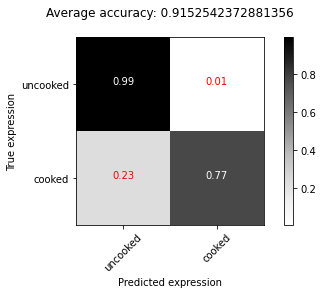

In [ ]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=np.array(('uncooked', 'cooked')),
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')